In [1]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from me0.data.datasets.image import ME0DigiImageDataset
from me0.modules.cnn.model import ME0SegCNN3d
from me0.losses import ME0BCELoss

torch.set_num_threads(5)

In [2]:
model = ME0SegCNN3d(
    in_channels = 3, # (hitmap, cls, bx)
    out_channels = 1,
    hidden_channels_list = [2, 4, 2],
    kernel_size = (3, 3, 7),
    activation = "GELU",
).to_tensor_dict_module()

model

TensorDictModule(
    module=ME0SegCNN3d(
      (activation): GELU(approximate='none')
      (residual_block_list): ModuleList(
        (0): ResidualBlock(
          (convbn1): ConvBn(
            (conv): Conv3d(3, 2, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=same, bias=False)
            (bn): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (activation): GELU(approximate='none')
          (convbn2): ConvBn(
            (conv): Conv3d(2, 2, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=same, bias=False)
            (bn): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (res): Conv3d(3, 2, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        )
        (1): ResidualBlock(
          (convbn1): ConvBn(
            (conv): Conv3d(2, 4, kernel_size=(3, 3, 7), stride=(1, 1, 1), padding=same, bias=False)
            (bn): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True

In [3]:
dataset = ME0DigiImageDataset(
    file='../data/step4_0.h5',
    features={
        'cls': {'min': 1, 'max': 384},
        'bx': {'min': -3, 'max': 3},
    },
    get_central_bx=True,
)

processing 35430 events: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.39s/it]


In [4]:
n_train = 1024
n_val = 256

train_loader = DataLoader(dataset[:n_train], collate_fn=dataset.collate, shuffle=True, drop_last=True, batch_size=64)
val_loader = DataLoader(dataset[n_train:n_train+n_val], collate_fn=dataset.collate, shuffle=False, drop_last=True, batch_size=128)

In [5]:
batch = next(iter(train_loader))
batch

TensorDict(
    fields={
        data_mask: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.bool, is_shared=False),
        eta: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        input: Tensor(shape=torch.Size([64, 3, 8, 6, 384]), device=cpu, dtype=torch.float32, is_shared=False),
        phi: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        pt: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.int32, is_shared=False)},
    batch_size=torch.Size([64]),
    device=None,
    is_shared=False)

In [6]:
out = model(batch)
out

TensorDict(
    fields={
        data_mask: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.bool, is_shared=False),
        eta: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        input: Tensor(shape=torch.Size([64, 3, 8, 6, 384]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.float32, is_shared=False),
        phi: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        preds: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.float32, is_shared=False),
        pt: Tensor(shape=torch.Size([64, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        target: Tensor(shape=torch.Size([64, 8, 6, 384]), device=cpu, dtype=torch.int32, is_shared=False)},
    batch_size=torch.Size([64]),
    device=None,
    is_shared=False)

In [7]:
pad_mask = batch['data_mask'].logical_not()

(out['preds'] == torch.sigmoid(out['logits']).masked_fill(pad_mask, 0.)).all(dim=(1,2,3))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [8]:
num_pos = 0
num_neg = 0
for batch in tqdm(train_loader):
    neg, pos = torch.bincount(batch['target'][batch['data_mask']])
    num_pos += pos
    num_neg += neg

pos_weight = num_neg / num_pos
print(f"{pos_weight=}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.96it/s]

pos_weight=tensor(72.3119)


In [9]:
loss_fn = ME0BCELoss(pos_weight=pos_weight).to_tensor_dict_module()

loss = loss_fn(out)['loss']
loss.backward()
print(f"{loss=}")

loss=tensor(1.8912, grad_fn=<DivBackward0>)


In [10]:
optim = torch.optim.AdamW(model.parameters(), lr=0.003)

out_df = pd.DataFrame(columns=['epoch', 'step', 'train_loss', 'val_loss'])

num_epoch = 5
step = 0

for epoch in range(num_epoch+1):
    # validation
    if epoch == 0:
        with torch.inference_mode():
            loss = 0
            for batch in tqdm(val_loader):
                out = model(batch)
                loss += loss_fn(out)['loss'].item()
            out_df.loc[len(out_df)] = [epoch, step, None, loss/len(val_loader)]
        print(f"""
        Epoch {epoch}/{num_epoch}
            val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
        """)            
        continue
    for batch in tqdm(train_loader):
        optim.zero_grad()
        out = model(batch)
        loss = loss_fn(out)['loss']
        loss.backward()
        optim.step()
        out_df.loc[len(out_df)] = [epoch, step, loss.item(), None]
        step += 1
        
    with torch.inference_mode():
        loss = 0
        for batch in tqdm(val_loader):
            out = model(batch)
            loss += loss_fn(out)['loss'].item()
        out_df.loc[len(out_df)] = [epoch, step, None, loss/len(val_loader)]
    
    print(f"""
    Epoch {epoch}/{num_epoch}
        train_loss: {out_df[(out_df['epoch'] == epoch)]['train_loss'].dropna().mean()}
        val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
    """)    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.16it/s]



        Epoch 0/5
            val_loss: 1.9075534343719482
        


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.09it/s]



    Epoch 1/5
        train_loss: 0.8436687923967838
        val_loss: 0.4645197242498398
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.89it/s]



    Epoch 2/5
        train_loss: 0.4154525902122259
        val_loss: 0.3436017632484436
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.92it/s]



    Epoch 3/5
        train_loss: 0.281967512331903
        val_loss: 0.2562573775649071
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.94it/s]



    Epoch 4/5
        train_loss: 0.21070260368287563
        val_loss: 0.2189709171652794
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.22it/s]


    Epoch 5/5
        train_loss: 0.1645658053457737
        val_loss: 0.21668016910552979
    


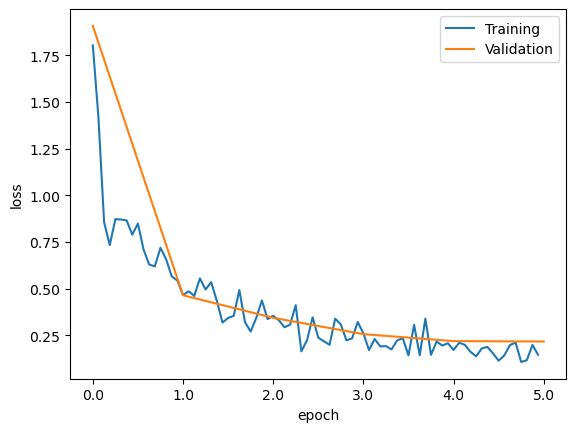

In [11]:
plt.plot(out_df[out_df['train_loss'].notna()]['step'], out_df['train_loss'].dropna(), label='Training')
plt.plot(out_df[out_df['val_loss'].notna()]['step'], out_df['val_loss'].dropna(), label='Validation')
plt.xticks(ticks=out_df[out_df['val_loss'].notna()]['step'], labels=out_df[out_df['val_loss'].notna()]['epoch'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()